# Training the final model

This notebook is supplementary material to the project here, which aims to re-implement the Hubble.2d6 tool to predict the function of CYP2D6 star alleles.

Within this notebook, the final model in the sequence outlined in the paper is trained using transfer learning. Weights from the first step are loaded into the new model. The fully-connected layers of the first model are replaced with new, randomly initialised layers and trained on 31 star alleles and their respective suballeles.

Please keep in mind that this implementation is incomplete due to the lack of resources to compute robust annotation embeddings of all variants for all star alleles.

Additionally, in the paper, this model is supposed to instead have its weights - along with weights of one of the fully-connected layers - loaded in from the second model in the sequence. However, due to data availability, I was unable to reproduce the implementation of the second model and instead chose to transfer just the convolution layers' weights to the final model from the first model that was trained on simulated data.

## Getting ready

**Acknowledgements**: Pre-computed annotation embeddings used are form the original Hubble.2d6 repo: https://github.com/gregmcinnes/Hubble2D6/tree/master/data

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(1337)

In [3]:
!git clone https://github.com/Locrian24/seng474-term-project.git
!cd seng474-term-project/ && git pull

Cloning into 'seng474-term-project'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 206 (delta 66), reused 175 (delta 38), pack-reused 0
Receiving objects: 100% (206/206), 26.65 MiB | 29.57 MiB/s, done.
Resolving deltas: 100% (66/66), done.
Already up to date.


In [4]:
import sys
sys.path.insert(0, '/content/seng474-term-project/model')

In [5]:
device_name = tf.test.gpu_device_name()
if device_name == '':
  print("If you are running the cross-validation below, please make sure to put on the GPU Runtime")

## Preparing the data

The vcf file of the star alleles used were provided from the paper and can be found **here**. 

### Encoding method

The script `build_label_csv.py` was run on this vcf file to output the label csv that will be used for training.

Labels for the data correspond to the ordinal classes describing the function of each CYP2D6 star allele and their respective suballeles: "No function", "Decreased function", and "Normal function".

The model however is required to output two scores, representing the probability of a star allele being "No function" and "Normal function" respectively, and therefore a binary scoring system is used to encode the 3 function classes into these two scores. 

The scoring system is as follows:
- "No function" alleles are indicated with a 0 as the first score, with all other functions being denoted with a 1
- "Normal function" alleles are indicated with a 1 as the second score, with all other functions being denoted with a 0.

This yields the following encodings:
- "No function" = `[0, 0]`
- "Decreased function" = `[0, 1]`
- "Normal function" = `[1, 1]`

**Note**: Star alleles with uncurated function have an empty label (`[None, None]`). 

_Sequence encodings are done exactly the same as in step 1_

In [6]:
from encode_to_seq import Encode2Seq

# Global variables rn for testing

ANNOTATIONS = '/content/seng474-term-project/data/gvcf2seq.annotation_embeddings.csv'
EMBEDDINGS = '/content/seng474-term-project/data/embeddings.txt'
REF = '/content/seng474-term-project/data/ref.seq'

VCF = '/content/seng474-term-project/step3/data/star_samples.vcf'
LABELS = '/content/seng474-term-project/step3/data/labels.csv'

encoding = Encode2Seq(vcf=VCF, labels=LABELS, label_cols=[0, 1, 2], embedding_file=EMBEDDINGS, annotation_file=ANNOTATIONS, ref_seq=REF)

### Seperation of data sets

The paper indicates that they used 31 star alleles and their suballeles as training data, and 24 alleles to compose the test data. Additionally, 10% of the each functional class ("No function", "Decreased function", and "Normal function") were held out for validation during training.

All star alleles with "Uncurated function" were ignored, and held from training/testing for obvious reasons.

In [7]:
# Select only star alleles with curated function

mask = np.all(np.isnan(encoding.y) == False, axis=1)

sample_y = encoding.y[mask]
sample_X = encoding.X[mask.reshape(-1, 1).any(axis=1)]
sample_names = encoding.sample_names[mask]

In [8]:
# Get valid stars
all_stars = np.array([s.split('_')[1] for s in sample_names])
stars, idx = np.unique(all_stars, return_index=True)

# Choose which stars are training and which are test: (31, 24) split
# Should be stratified with labels
train_idx, test_idx = train_test_split(idx, stratify=sample_y[idx], test_size=24, random_state=1)

# Retrieve indices of training and test stars
sample_mask = np.isin(all_stars, all_stars[train_idx])

test_stars = np.array([s for s in sample_names[~sample_mask] if s.split('_')[-1] == '001'])
test_mask = np.isin(sample_names, test_stars)

train_stars = np.array([s for s in sample_names[sample_mask] if s.split('_')[-1] == '001'])
train_mask = np.isin(sample_names, train_stars)

# Split the data into the two sets - INCLUDING SUBALLES ON BOTH
_train_X, test_X = sample_X[sample_mask], sample_X[~sample_mask]
_train_y, test_y = sample_y[sample_mask], sample_y[~sample_mask]

# Purely for evaluation (paper looks at star allele accuracy rather than star + suballeles)
star_train_X, star_test_X = sample_X[train_mask], sample_X[test_mask]
star_train_y, star_test_y = sample_y[train_mask], sample_y[test_mask]

In [9]:
# Uncurated star alleles

uncurated_samples = encoding.sample_names[~mask]
uncurated_stars = np.array([s for s in uncurated_samples if s.split('_')[-1] == '001'])
uncurated_star_mask = np.isin(uncurated_samples, uncurated_stars)

uncurated_samples = uncurated_samples[uncurated_star_mask]
uncurated_X = encoding.X[(~mask).reshape(-1, 1).any(axis=1)]
uncurated_X = uncurated_X[uncurated_star_mask]

### Prepare data for the model

In [10]:
_train_ds = tf.data.Dataset.from_tensor_slices((_train_X, _train_y))
train_ds = _train_ds.repeat().shuffle(_train_X.shape[0], reshuffle_each_iteration=True).batch(32).prefetch(buffer_size=10)

_test_ds = tf.data.Dataset.from_tensors((test_X, test_y))
test_ds = _test_ds.prefetch(buffer_size=10)

## Building the final model

As stated earlier, the model is loaded from the generated model from step 1, and also inherits its learned weights.

In [11]:
epochs = 6
fine_tune_epochs = 2
steps_per_epoch = 128
steps_per_epoch_ft = 64
lr = 0.001
lr_ft = 1e-5

def build_and_fit(train_dataset, val_dataset=None):
  json_file = open('/content/seng474-term-project/step_1/model.json', 'r')
  loaded_model = json_file.read()
  model = tf.keras.models.model_from_json(loaded_model)
  model.load_weights('/content/seng474-term-project/step_1/weights.h5')
  
  # Remove fully connected layers
  model.pop()
  model.pop()
  model.pop()
  model.trainable = False

  # Build final model
  inputs = tf.keras.Input(shape=(14868, 13))
  x = model(inputs, training=False)
  x = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu, kernel_initializer=tf.keras.initializers.VarianceScaling(mode='fan_avg', distribution='uniform'), name = "dense_5")(x)
  x = tf.keras.layers.Dropout(rate=0.03, name="dropout_4")(x)
  x = tf.keras.layers.Dense(1, activation=tf.keras.activations.linear, kernel_initializer=tf.keras.initializers.VarianceScaling(mode='fan_avg', distribution='uniform'), name = "dense_6")(x)
  outputs = tf.keras.layers.Dense(2, activation=tf.keras.activations.sigmoid, kernel_initializer=tf.keras.initializers.VarianceScaling(mode='fan_avg', distribution='uniform'), name = "final_dense")(x)
  final_model = tf.keras.Model(inputs, outputs)

  if val_dataset is None:
    with tf.device('/device:GPU:0'):
      # Initial training
      final_model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        # loss=tf.keras.losses.BinaryCrossentropy(),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.AUC()]
      )

      final_model.fit(train_dataset, epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=True)

      # Fine tuning
      model.trainable = True
      final_model.compile(
          optimizer=tf.keras.optimizers.SGD(1e-5, momentum=0.8, nesterov=True),
          # loss=tf.keras.losses.BinaryCrossentropy(),
          loss=tf.keras.losses.MeanSquaredError(),
          metrics=[tf.keras.metrics.AUC()]
      )

      final_model.fit(train_dataset, epochs=fine_tune_epochs, steps_per_epoch=steps_per_epoch_ft, verbose=True)
    
  else:
    with tf.device('/device:GPU:0'):
      # Initial training
      final_model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        # loss=tf.keras.losses.BinaryCrossentropy(),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.AUC()]
      )

      final_model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, steps_per_epoch=steps_per_epoch, validation_steps=1, verbose=True)

      # Fine tuning
      model.trainable = True
      final_model.compile(
          optimizer=tf.keras.optimizers.SGD(1e-5, momentum=0.8, nesterov=True),
          # loss=tf.keras.losses.BinaryCrossentropy(),
          loss=tf.keras.losses.MeanSquaredError(),
          metrics=[tf.keras.metrics.AUC()]
      )

      final_model.fit(train_dataset, epochs=fine_tune_epochs, validation_data=val_dataset, steps_per_epoch=64, validation_steps=1, verbose=True)
  
  return final_model

## Setup for the ensemble

This step is basically identical to how the final implementation of this project builds the ensemble, with its purpose being here for evaluation purposes. The only difference is it's ability to use other saved models specified elsewhere (used for CV).

In [12]:
class Ensemble():
  def __init__(self, X=None, dir='/content/seng474-term-project/data/ensemble_models/'):
    self.X = X
    self.raw = None
    self.predictions = None
    self.dir = dir

    self.run()

  def run(self):
    predictions = self.predict(self.X).mean(axis=0)
    self.raw = predictions
    self.predictions = self.get_functions(predictions)

  def get_functions(self, pred):
    cutpoint_1 = 0.4260022
    cutpoint_2 = 0.7360413

    cut1 = np.greater(pred[:, 0], [cutpoint_1])
    cut2 = np.greater(pred[:, 1], [cutpoint_2])

    functions = []
    for i in range(pred.shape[0]):
      if cut1[i] == True and cut2[i] == True:
        functions.append("Normal Function")
      elif cut1[i] == True and cut2[i] == False:
        functions.append("Decreased Function")
      else:
        functions.append("No Function")

    return np.array(functions)

  def evaluate(self, y):
    labels = self.get_functions(y)
    return np.sum(labels == self.predictions) / len(y)

  def predict(self, X):
    from glob import glob
    models = glob(self.dir + "*.model.h5")
    
    predictions = []
    print("Predicting...")
    for m in models:
      # print(f"Predicting using {m}")
      model = tf.keras.models.load_model(m)
      
      pred = model.predict(X)
      predictions.append(pred)

    return np.array(predictions)

## Hyperparameter tuning with 5-fold stratified CV

Here is the code run to tune hyperparameters, such as batch sizes, learning rates, and even optimisers. This cross-validation was done mainly manually due to the need to mess around with various combinations of optimisers and hyperparameters.

The hyperparameters used in this notebook (see above) are the final ones chosen from this method, and reduce overfitting and increase the stability of the model's prediction, at a cost of training accuracy.

From this CV, it was clear that this model overfit easily to the point that very high training accuracy led to a sharp decrease in validation accuracy in regard to the labels. As a result, as seen below on the actual model that was trained, we get about 85-90% accuracy on the training data as opposed to the 100% accuracy achieved by the original paper.

In [13]:
# from sklearn.model_selection import StratifiedShuffleSplit
# sss = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=0)
# fold = 1

# for train_index, val_index in sss.split(_train_X, _train_y):
#   train_X, val_X = _train_X[train_index], _train_X[val_index]
#   train_y, val_y = _train_y[train_index], _train_y[val_index]

#   _train_ds = tf.data.Dataset.from_tensor_slices((train_X, train_y))
#   train_ds = _train_ds.repeat().shuffle(train_X.shape[0], reshuffle_each_iteration=True).batch(32).prefetch(buffer_size=10)
#   _val_ds = tf.data.Dataset.from_tensors((val_X, val_y))
#   val_ds = _val_ds.prefetch(buffer_size=10)

#   model = build_and_fit(train_ds, val_ds)
#   model.save(f'model_{fold}/ensemble.model.h5')

#   val_ensemble = Ensemble(val_X, dir=f"/content/model_{fold}/")
#   print(f"Fold {fold} validation accuracy:", val_ensemble.evaluate(val_y))

#   fold += 1

_Hyperparameters_:
- Batch size: **32**
- Epochs: **6**
- Fine tuning epochs: **2**
- Initial learning rate (Adam): **0.001**
- Main training steps_per_epoch: **128**
- Fine tuning learning rate (SGD): **1e-5, momentum=0.8**
- Fine tuning steps_per_epoch: **64**

## Training ensemble models

Hubble.2d6 uses an ensemble averaging method for it's final predictions. Here we are training 7 models to use in the ensemble, report the training accuracy of each and save these models for the final tool. Hyperparameters used are ones tuned through the about method.

Since the dataset is relatively small, and we have already run CV on validation sets, each model of the ensemble is trained on the entire training set.

In [14]:
ensemble_size = 7

for i in range(ensemble_size):
  print(f"ensemble_{i}.model.h5")
  model = build_and_fit(train_ds)

  model.save(f'models/ensemble_{i}.model.h5')

ensemble_0.model.h5
Epoch 1/6
128/128 [==============================] - 33s 22ms/step - loss: 0.0982 - auc: 0.9419
Epoch 2/6
128/128 [==============================] - 3s 22ms/step - loss: 0.0695 - auc: 0.9718
Epoch 3/6
128/128 [==============================] - 3s 21ms/step - loss: 0.0596 - auc: 0.9798
Epoch 4/6
128/128 [==============================] - 3s 22ms/step - loss: 0.0546 - auc: 0.9828
Epoch 5/6
128/128 [==============================] - 3s 22ms/step - loss: 0.0489 - auc: 0.9856
Epoch 6/6
128/128 [==============================] - 3s 22ms/step - loss: 0.0457 - auc: 0.9867
Epoch 1/2
64/64 [==============================] - 4s 26ms/step - loss: 0.0424 - auc_1: 0.9880
Epoch 2/2
64/64 [==============================] - 2s 25ms/step - loss: 0.0421 - auc_1: 0.9882
ensemble_1.model.h5
Epoch 1/6
128/128 [==============================] - 4s 22ms/step - loss: 0.1152 - auc_2: 0.9267
Epoch 2/6
128/128 [==============================] - 3s 22ms/step - loss: 0.0777 - auc_2: 0.9647
Epoch

Now that we have the ensemble models saved, we will use them for the final prediction.

### Important

From now on, we use the final version of the paper implementation to show true performance.

It is definitely possible to change the path where the weights exist in the colab project and train a new ensemble above.

In [15]:
# Training data - INCLUDES SUBALLELES

train_ensemble = Ensemble(_train_X, dir='/content/models/')
print("\nTraining Accuracy (with suballeles):", train_ensemble.evaluate(_train_y))

Predicting...

Training Accuracy (with suballeles): 0.7987421383647799


In [16]:
# Original paper attains 100% accuracy on training data star alleles

star_train_ensemble = Ensemble(star_train_X, dir='/content/models/')
print("\nTraining Accuracy (only star alleles):", star_train_ensemble.evaluate(star_train_y))

Predicting...

Training Accuracy (only star alleles): 0.8387096774193549


## Initial Evaluation

The purpose here is to properly quantify the accuracy of predictions by decoding the scoring system into their respective labels.

**Note:** Training set contain suballele predictions. Suballeles of a given star allele _should_ have the same prediction, and so some star alleles with many more suballeles than others may affect the accuracy score. As a result, training data is evaluated 

In [17]:
import seaborn as sb
import matplotlib.pyplot as plt

def build_heatmap(pred, y, labels):
  heatmap = []
  for label in labels:
    mask = pred == label
    masked_labels = y[mask]
    heatmap.append([len(masked_labels[masked_labels == l]) for l in reversed(labels)])

  return heatmap

Text(0.5, 1.0, 'Training set')

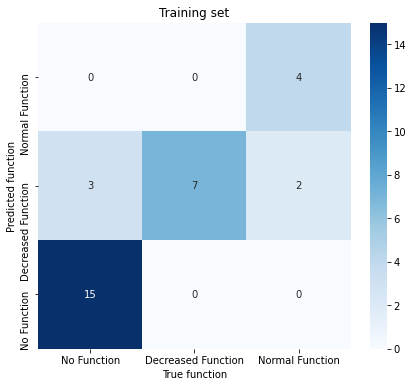

In [18]:
labels = ["Normal Function", "Decreased Function", "No Function"]

train_labels = star_train_ensemble.get_functions(star_train_y)
train_heatmap = build_heatmap(star_train_ensemble.predictions, train_labels, labels)

fig = plt.figure()
fig.set_size_inches(7, 6)

sb.heatmap(train_heatmap, cmap="Blues", annot=train_heatmap, xticklabels=list(reversed(labels)), yticklabels=labels)

plt.xlabel("True function")
plt.ylabel("Predicted function")
plt.title("Training set")

## Final Evaluation

Here we evaluate the final predictive ability of the implementation of the Hubble.2d6 paper.

**Note**: We are using the models constructed in the previous step. Remove the `dir` param in all `Ensemble` initialisations to use the final models saved in the final project.

Predicting...

Test Accuracy + suballeles: 0.7017543859649122


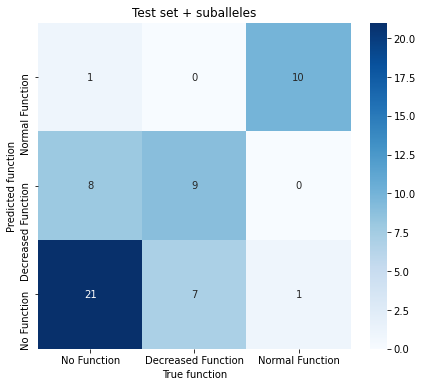

In [19]:
# All test star alleles + suballeles

test_ensemble = Ensemble(test_X, dir='/content/models/')
test_labels = test_ensemble.get_functions(test_y)
test_heatmap = build_heatmap(test_ensemble.predictions, test_labels, labels)

fig = plt.figure()
fig.set_size_inches(7, 6)
sb.heatmap(test_heatmap, cmap="Blues", annot=test_heatmap, xticklabels=list(reversed(labels)), yticklabels=labels)
plt.xlabel("True function")
plt.ylabel("Predicted function")
plt.title("Test set + suballeles")

print("\nTest Accuracy + suballeles:", test_ensemble.evaluate(test_y))

Predicting...

Test Accuracy: 0.7916666666666666


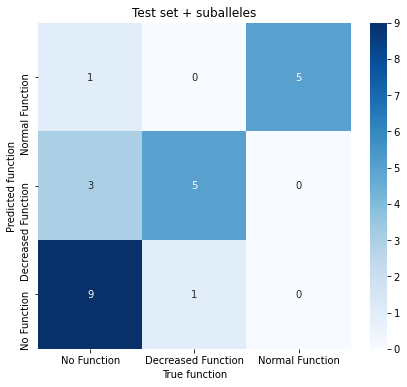

In [20]:
# All test star alleles

test_ensemble = Ensemble(star_test_X, dir='/content/models/')
test_labels = test_ensemble.get_functions(star_test_y)
test_heatmap = build_heatmap(test_ensemble.predictions, test_labels, labels)

fig = plt.figure()
fig.set_size_inches(7, 6)
sb.heatmap(test_heatmap, cmap="Blues", annot=test_heatmap, xticklabels=list(reversed(labels)), yticklabels=labels)
plt.xlabel("True function")
plt.ylabel("Predicted function")
plt.title("Test set + suballeles")

print("\nTest Accuracy:", test_ensemble.evaluate(star_test_y))

As you can see, on only star alleles, we achieve around 80% accuracy. With more inaccuracy with the set containing all respective suballeles.

Based on the heatmap, the biggest error in prediction (on the test set) is a higher rate of predicting "Decreased Function" on haplotype with "No Function"